In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
from collections import deque

class Memory:
    def __init__(self, capacity=50):
        self.memories = deque()
        self.capacity = capacity
        self.n = len(self.memories)
    
    def forget(self):
        self.memories.popleft()
        self.n -= 1
    
    def remember(self, experience):
        self.memories.append(experience)
        self.n += 1
        if len(self.memories) > self.capacity:
            self.forget()
        
    def sample(self, n=1):
        idx = np.random.choice(range(len(self.memories)),n)
        return np.take(self.memories, idx, axis=0)

In [4]:
#--------------------------------
# Defining Actor and Critic networks below
#--------------------------------
tf.reset_default_graph()

# environment dimensions
s_shape = env.observation_space.shape[0]
a_shape = env.action_space.n

In [5]:
#--------------------------------
# Critic Neural Network (evaluates Actor decisions based on utility)
#--------------------------------

# input placeholder
S = tf.placeholder(tf.float32,[None,s_shape],name='state_input')

# simple mlp with "s_shape" inputs, 20 hidden units, 1 output
hc=20
w1c = tf.get_variable("W1c", [s_shape,hc], initializer = tf.keras.initializers.he_normal(seed=1))
b1c = tf.get_variable("B1c", [1,hc], initializer = tf.keras.initializers.he_normal(seed=1))
z1c = tf.add(tf.matmul(S,w1c),b1c)
a1c = tf.nn.relu(z1c)

w2c = tf.get_variable("W2c", [hc,1], initializer = tf.keras.initializers.he_normal(seed=1))
b2c = tf.get_variable("B2c", [1,1], initializer = tf.keras.initializers.he_normal(seed=1))
Qnet = tf.add(tf.matmul(a1c,w2c),b2c)

# loss = MSE q value prediction
Qtarget = tf.placeholder(shape=[None,],dtype=tf.float32)
loss_c = tf.reduce_mean(tf.square(tf.subtract(Qtarget,Qnet)))
trainer_c = tf.train.AdamOptimizer()
updateCritic = trainer_c.minimize(loss_c)

In [6]:
#--------------------------------
# Actor Neural Network (learns non-deterministic policy based on critic feedback)
#--------------------------------

# input placeholder
actions = tf.placeholder(tf.int32, [None, a_shape], name='true_actions')
td_error = tf.placeholder(tf.float32, [None,], name='temporal_difference_error')

# simple mlp with "s_shape" inputs, 20 hidden units, "a_shape" outputs
ha=20
w1a = tf.get_variable("W1a", [s_shape, ha], initializer = tf.keras.initializers.he_normal(seed=1))
b1a = tf.get_variable("B1a", [1, ha], initializer = tf.keras.initializers.he_normal(seed=1))
z1a = tf.add(tf.matmul(S,w1a),b1a)
a1a = tf.nn.relu(z1a)

w2a = tf.get_variable("W2a", [ha, a_shape], initializer = tf.keras.initializers.he_normal(seed=1))
b2a = tf.get_variable("B2a", [1, a_shape], initializer = tf.keras.initializers.he_normal(seed=1))
logits = tf.add(tf.matmul(a1a,w2a),b2a)

# non-deterministic actions 
softmax_output = tf.nn.softmax(logits)

# loss = log likelihood action probabilities modulated by critic feedback
labels = actions
neg_log_likelihood = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
loss_a = tf.reduce_mean(neg_log_likelihood * td_error)
trainer_a = tf.train.AdamOptimizer()
updateActor = trainer_a.minimize(loss_a)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Critic Network | Actor Network
-|-
![network_diagram](../diagrams/critic_network_img "Critic-Network Structure") | ![network_diagram](../diagrams/actor_network_img "Actor-Network Structure")

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
#--------------------------------
# Learning parameters
#--------------------------------
alpha = 0.5
gamma = 0.99
epsilon = 1.0
decay = 0.999

alpha_min = 0.1
epsilon_min = 0.1

In [10]:
n_episodes = 2000
N_ACTIONS = env.action_space.n
reward_history = []

#--------------------------------
# Iterate through pole balancing episodes
#--------------------------------
for episode in range(n_episodes):
    
    s = env.reset()
    rsum = 0
    explore_rate = max(epsilon_min, epsilon*decay**episode)

    #--------------------------------
    # individual steps through a single episode
    #--------------------------------
    while True:
        #--------------------------------
        # Non-deterministic actions from actor network
        #--------------------------------
        policy_output = sess.run(softmax_output, feed_dict={S:np.atleast_2d(s)})
        a = np.random.choice(range(len(policy_output.ravel())), p=policy_output.ravel())
        if np.random.uniform() < explore_rate:
            a = np.random.choice(range(N_ACTIONS))  
            
        #--------------------------------
        # Take selected action
        #--------------------------------    
        sp, r, d, _ = env.step(a)
        
        #--------------------------------
        # TD Error for critic update
        #--------------------------------
        Q = sess.run(Qnet,feed_dict={S:np.atleast_2d(s)})
        Qp = sess.run(Qnet,feed_dict={S:np.atleast_2d(sp)})

        if d:
            Qupdate = (1-alpha)*Q + alpha*(r)
        else:
            Qupdate = (1-alpha)*Q + alpha*(r+gamma*Qp)
        tde = Qupdate-Q
        
        _, lc = sess.run([updateCritic,loss_c], feed_dict={S:np.atleast_2d(s),Qtarget:Qupdate.ravel()})
        a_ohe = np.atleast_2d(np.eye(2)[a])
        _, la = sess.run([updateActor,loss_a], feed_dict={S:np.atleast_2d(s),actions:a_ohe,td_error:tde.ravel()})

        s = sp
        rsum += r
        if d:
            break

    reward_history.append(rsum)
    #--------------------------------
    # Print out progress indicators 
    #--------------------------------
    if episode%50==0:
        print("Episode {}: Avg Reward = {}, Exploration Rate = {:.3f}, Actor Loss = {:.3f}, Critic Loss = {:.3f}".format(
            episode,np.mean(reward_history[-50:]),explore_rate,la,lc))

Episode 0: Avg Reward = 16.0, Exploration Rate = 1.000, Actor Loss = -3.986, Critic Loss = 1.750
Episode 50: Avg Reward = 20.42, Exploration Rate = 0.951, Actor Loss = -1.855, Critic Loss = 21.738
Episode 100: Avg Reward = 19.22, Exploration Rate = 0.905, Actor Loss = -0.010, Critic Loss = 28.293
Episode 150: Avg Reward = 18.56, Exploration Rate = 0.861, Actor Loss = -35.957, Critic Loss = 41.900
Episode 200: Avg Reward = 18.38, Exploration Rate = 0.819, Actor Loss = -0.000, Critic Loss = 16.248
Episode 250: Avg Reward = 17.74, Exploration Rate = 0.779, Actor Loss = -0.037, Critic Loss = 38.717
Episode 300: Avg Reward = 16.78, Exploration Rate = 0.741, Actor Loss = -0.001, Critic Loss = 9.582
Episode 350: Avg Reward = 15.44, Exploration Rate = 0.705, Actor Loss = -0.173, Critic Loss = 19.524
Episode 400: Avg Reward = 21.98, Exploration Rate = 0.670, Actor Loss = -0.788, Critic Loss = 11.385
Episode 450: Avg Reward = 31.94, Exploration Rate = 0.637, Actor Loss = -11.627, Critic Loss = 1

In [11]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

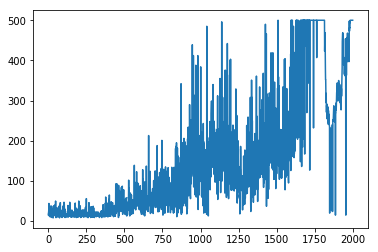

In [12]:
plt.plot(reward_history)

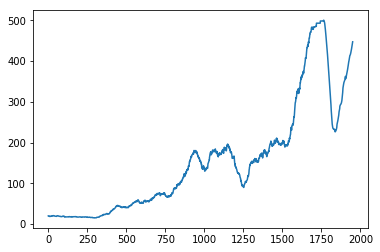

In [13]:
rmoving = running_mean(reward_history, 50)
plt.plot(rmoving)

---
## Run your trained agent for a random episode!

---

In [14]:
s = env.reset()
total_reward = 0
while True:
    policy_output = sess.run(softmax_output, feed_dict={S:np.atleast_2d(s)})
    a = np.random.choice(range(len(policy_output.ravel())), p=policy_output.ravel())
    sp, r, d, _ = env.step(a)
        
    env.render()

    total_reward += r
    s = sp
    if d:
        print(total_reward)
        break

500.0
